--- Loading Dataset ---
Initial shape: (2351, 4273)
Cleaned dataset: 4269 features (genes) across 2351 samples.
Target classes detected: 53

--- Running Feature Selection (Lasso) ---
Selection time: 22.89 seconds
Selected Features: 923 (reduced from 4269)

--- Training SVM ---
SVM Accuracy: 99.15%
--- Training KNN ---
KNN Accuracy: 93.84%

--- Detailed Results for Best Model: SVM ---


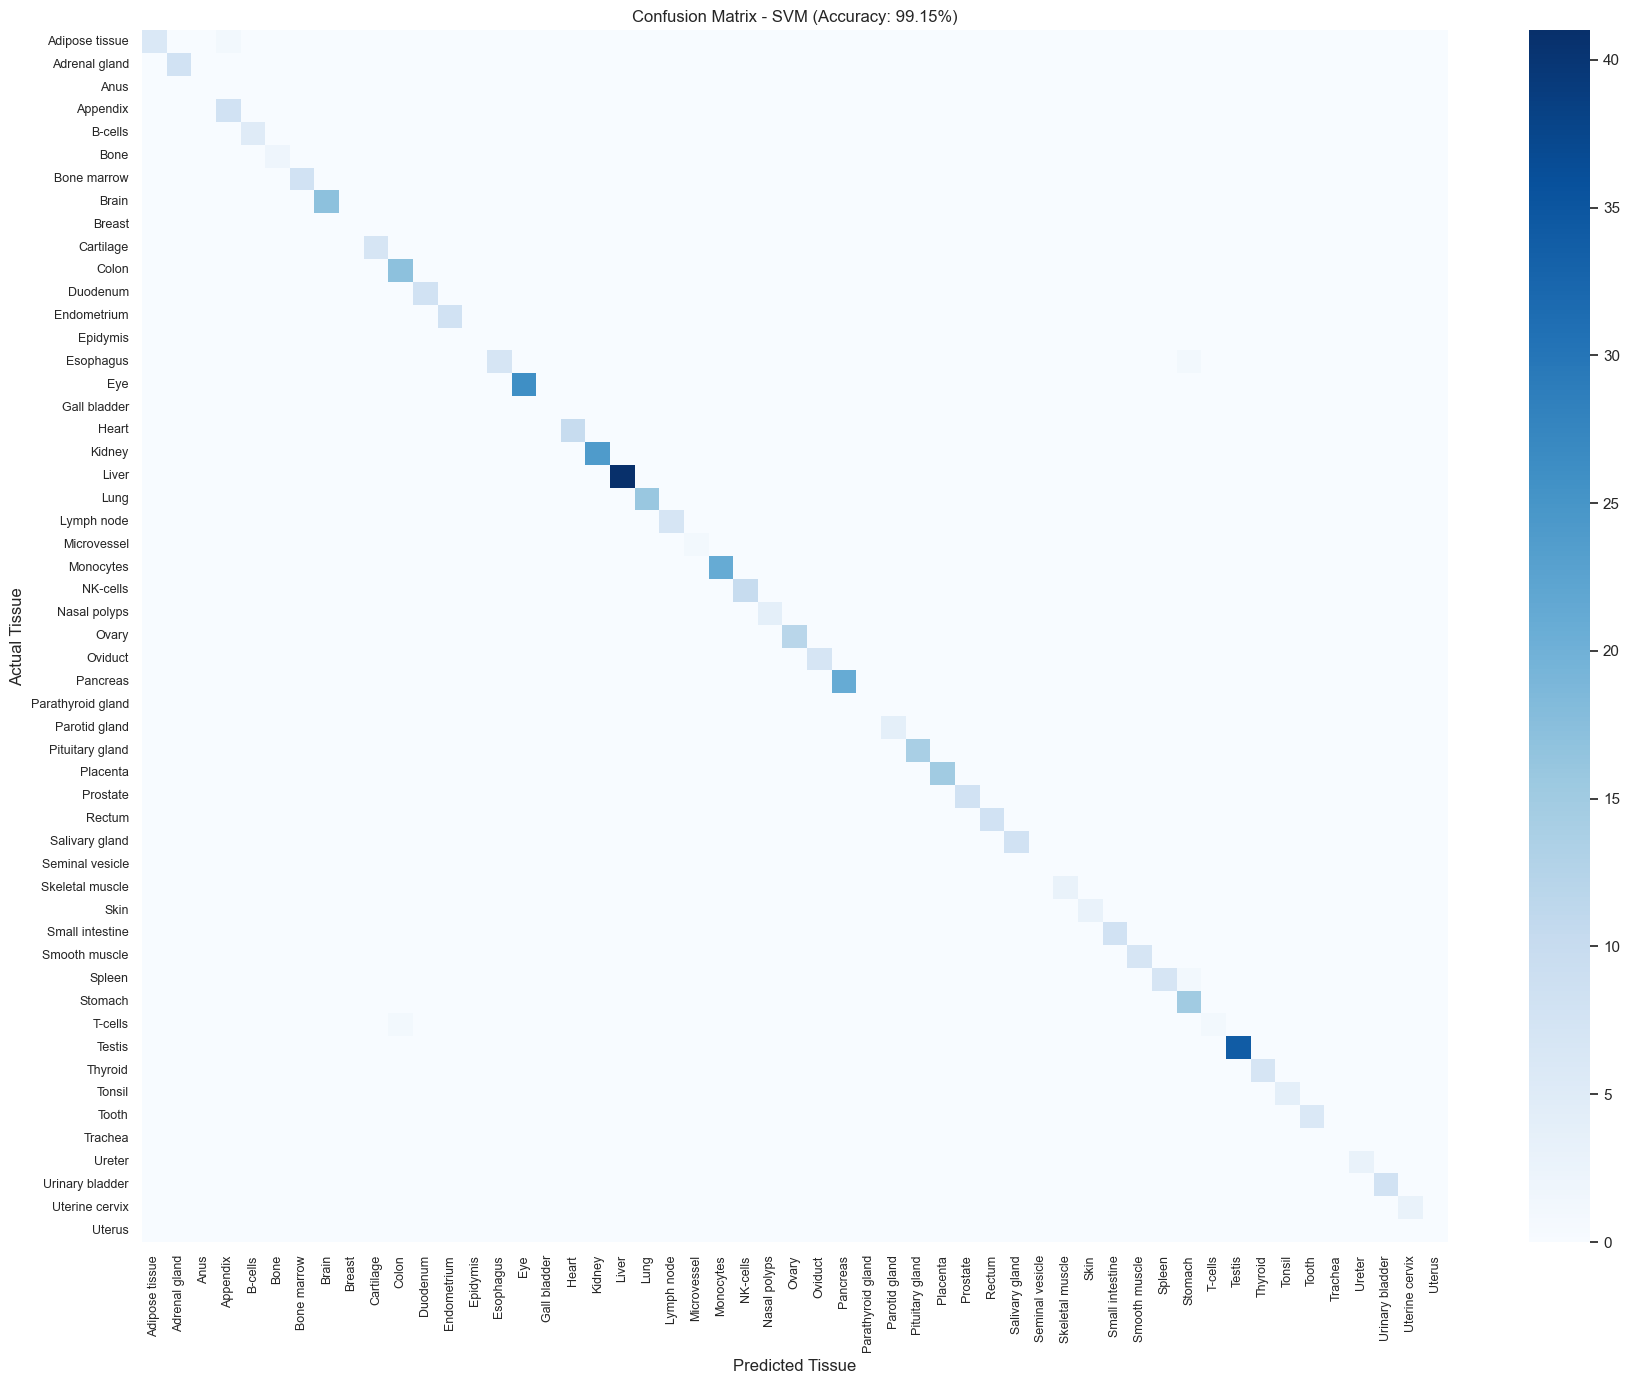

                   precision    recall  f1-score   support

   Adipose tissue       1.00      0.86      0.92         7
    Adrenal gland       1.00      1.00      1.00         8
             Anus       0.00      0.00      0.00         0
         Appendix       0.89      1.00      0.94         8
          B-cells       1.00      1.00      1.00         5
             Bone       1.00      1.00      1.00         2
      Bone marrow       1.00      1.00      1.00         8
            Brain       1.00      1.00      1.00        17
           Breast       0.00      0.00      0.00         0
        Cartilage       1.00      1.00      1.00         7
            Colon       0.94      1.00      0.97        17
         Duodenum       1.00      1.00      1.00         8
      Endometrium       1.00      1.00      1.00         8
         Epidymis       0.00      0.00      0.00         0
        Esophagus       1.00      0.88      0.93         8
              Eye       1.00      1.00      1.00       

In [22]:
# ====================================================================================
# 1. Library Imports
# ====================================================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set(style="whitegrid")

# ====================================================================================
# 2. Data Loading & Cleaning
# ====================================================================================

print("--- Loading Dataset ---")

# Load dataset (custom separator '/')
df = pd.read_csv('data/tissue_predictor_filtered_healthy_nofluid.csv', sep='/')
print(f"Initial shape: {df.shape}")

# Define metadata columns to drop (non-feature columns)
target_col = 'tissue_name'
metadata_cols = ['cell_type', 'tissue_name', 'disease_status', 'fluid']

# Separate Features (X) and Target (y)
cols_to_drop = [c for c in metadata_cols if c in df.columns]
X = df.drop(cols_to_drop, axis=1)
y = df[target_col]

print(f"Cleaned dataset: {X.shape[1]} features (genes) across {X.shape[0]} samples.")

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
print(f"Target classes detected: {len(class_names)}")

# ====================================================================================
# 3. Preprocessing (Split & Scaling)
# ====================================================================================

# Stratified split to maintain class distribution in test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Standardization (Z-score normalization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ====================================================================================
# 4. Feature Selection (Lasso Regularization)
# ====================================================================================

print("\n--- Running Feature Selection (Lasso) ---")

# Using L1-penalized Logistic Regression to enforce sparsity
# C=0.2 selected to maximize feature reduction while retaining signal
lasso_selector = LogisticRegression(
    penalty='l1', 
    C=0.2, 
    solver='liblinear', 
    random_state=42, 
    max_iter=1000
)

start_time = time.time()
lasso_selector.fit(X_train_scaled, y_train)
print(f"Selection time: {time.time() - start_time:.2f} seconds")

# Transform datasets to keep only selected features
model_selection = SelectFromModel(lasso_selector, prefit=True)
X_train_selected = model_selection.transform(X_train_scaled)
X_test_selected = model_selection.transform(X_test_scaled)

print(f"Selected Features: {X_train_selected.shape[1]} (reduced from {X_train.shape[1]})")

# ====================================================================================
# 5. Modeling (SVM vs KNN)
# ====================================================================================

# A. Support Vector Machine (Linear Kernel)
print("\n--- Training SVM ---")
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_selected, y_train)

y_pred_svm = svm_model.predict(X_test_selected)
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {acc_svm:.2%}")

# B. K-Nearest Neighbors (k=3)
print("--- Training KNN ---")
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_selected, y_train)

y_pred_knn = knn_model.predict(X_test_selected)
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {acc_knn:.2%}")

# ====================================================================================
# 6. Evaluation & Visualization
# ====================================================================================

# Select best model for detailed reporting
best_model_name = "SVM" if acc_svm >= acc_knn else "KNN"
best_preds = y_pred_svm if acc_svm >= acc_knn else y_pred_knn
best_acc = max(acc_svm, acc_knn)

print(f"\n--- Detailed Results for Best Model: {best_model_name} ---")

# Confusion Matrix Heatmap
plt.figure(figsize=(18, 14))
# Force all labels to appear to handle missing classes in test set
all_labels = np.arange(len(class_names))
cm = confusion_matrix(y_test, best_preds, labels=all_labels)

sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name} (Accuracy: {best_acc:.2%})')
plt.xlabel('Predicted Tissue')
plt.ylabel('Actual Tissue')
plt.xticks(rotation=90, fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

# Classification Report
print(classification_report(y_test, best_preds, target_names=class_names, labels=all_labels, zero_division=0))